### Análises Realizadas:
 * Cursos com mais empréstimos cadastrados (por nível do curso)
 * Número de emprestimos por ano
 * Frequência dos Tempos dos Empréstimos
 * 25 Títulos com mais anos em Empréstimo
 * 25 Títulos com o maior número de Empréstimos

In [1]:
# Importando o necessário
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Lendo os dados dos empréstimos
Dados_Emprestimos = glob("Dados_Abertos/Dados_Emprestimos/*.csv")
emprestimos = [pd.read_csv(f, sep=';') for f in sorted(Dados_Emprestimos)]

In [3]:
# Lendo os dados dos discentes
Dados_Discentes = glob("Dados_Abertos/Dados_Discentes/*.csv")
discentes = [pd.read_csv(f, sep=';') for f in sorted(Dados_Discentes)]

In [4]:
# Lendo os dados do acervo da biblioteca
acervo = pd.read_csv("Dados_Abertos/Dados_Biblioteca/acervo.csv", sep=';')
exemplares = pd.read_csv("Dados_Abertos/Dados_Biblioteca/exemplares.csv", sep=';')
exemplares_acervo = pd.read_csv("Dados_Abertos/Dados_Biblioteca/exemplares-acervo.csv", sep=';')

In [5]:
# Adicionando coluna 'ano' aos datasets 
so = sorted(Dados_Emprestimos)
for r in range(len(so)):
    emprestimos[r]['ano'] = int(so[r][-9:-5])

In [6]:
# Concatenando os datasets obtidos
emprestimos_all = pd.concat(emprestimos, ignore_index=True)
discentes_all = pd.concat(discentes, ignore_index=True)

# Filtrando dados a serem considerados
emprestimos_all = emprestimos_all[emprestimos_all.nome_usuario != "Usuário de Migração"]
discentes_curso = discentes_all[['nome_discente','ano_ingresso','nome_curso', 'nivel_ensino']]
discentes_curso = discentes_curso.set_index(['nome_discente','ano_ingresso'])

In [7]:
# Obtendo o numero de emprestimos de cada usuario por ano
usuarios = emprestimos_all.groupby(['nome_usuario','ano'])['id_emprestimo'].count()
# Limpando o nome de dois usuarios
usuarios.index = usuarios.index.set_levels(usuarios.index.unique(level=0).str.replace('\t', ''), level=0)
usuarios = usuarios.sort_index()
# Melhorando a Visualização
usuarios = pd.DataFrame(usuarios)
usuarios.columns = ['emprestimos']

In [8]:
# Preparando para o Merge
discentes_curso.index.levels[0].name = "nome"
discentes_curso.index.levels[1].name = "ano"
usuarios.index.levels[0].name = "nome"
usuarios.index.levels[1].name = "ano"

In [9]:
# Realizando o merge dos emprestimos do usuario naquele ano e o curso que ele cursa no ano
emprestimos_curso = pd.merge(discentes_curso, usuarios, left_index=True, right_index=True)

In [10]:
# Organizando por nivel de ensino
niveis_ensino = emprestimos_curso.nivel_ensino.unique()
emprestimos_curso_niveis = {nivel: emprestimos_curso[emprestimos_curso.nivel_ensino == nivel] for nivel in niveis_ensino}
emprestimos_curso_niveis = {nivel: pd.DataFrame(emprestimos_curso_niveis[nivel].groupby(['nome_curso'])['emprestimos'].sum()).sort_values(by='emprestimos', ascending=False) for nivel in niveis_ensino}
emprestimos_curso_niveis = {nivel: emprestimos_curso_niveis[nivel] for nivel in niveis_ensino}

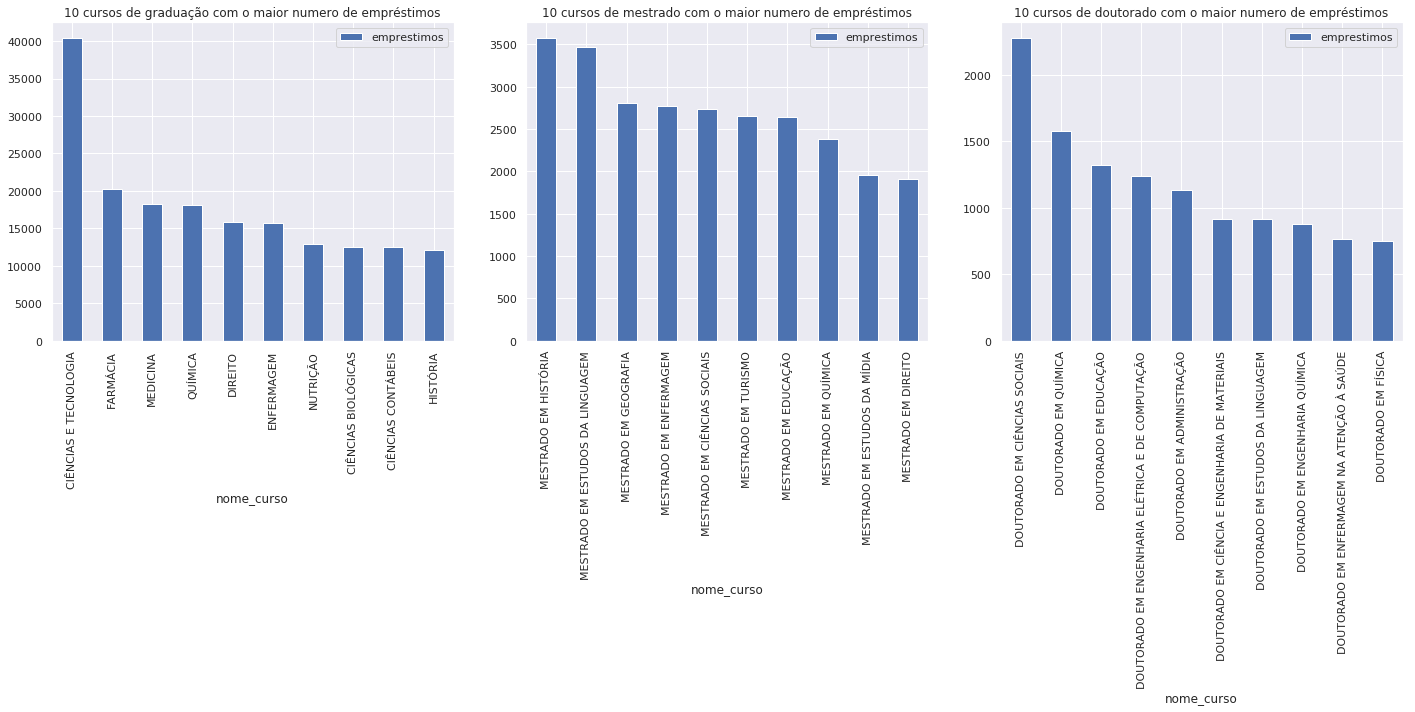

In [11]:
# Preparando Gráficos para os niveis comuns de ensino
niveis_ensino_padrao = ["GRADUAÇÃO", "MESTRADO", "DOUTORADO"]

fig, axes = plt.subplots(figsize=(20, 10),nrows=1, ncols=3)

generic_title = "10 cursos de %s com o maior numero de empréstimos"

for i in range(len(niveis_ensino_padrao)):
    emprestimos_curso_niveis[niveis_ensino_padrao[i]].head(10).plot.bar(title=generic_title % niveis_ensino_padrao[i].lower(), ax=axes[i])

plt.tight_layout()
plt.show()

Podemos peceber que o Curso de Ciência e Tecnologia é o que mais tem alunos que pegam livros emprestados.
Talvez isso aconteça pelo grande numero de alunos que o cursam.

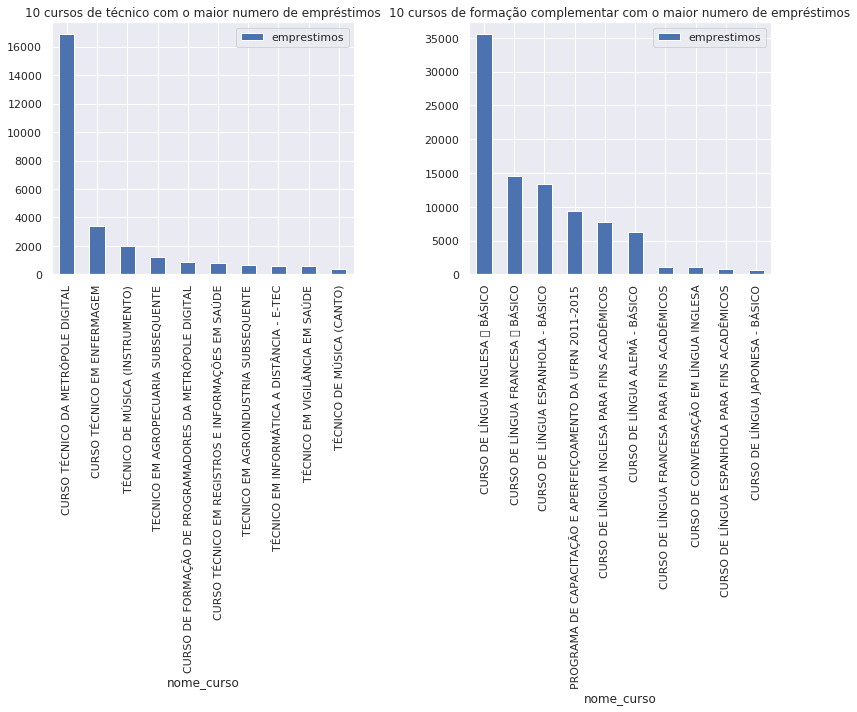

In [12]:
# Preparando Gráficos para os outros niveis de ensino
niveis_ensino_outros = ["TÉCNICO","FORMAÇÃO COMPLEMENTAR"]

fig, axes = plt.subplots(figsize=(12, 10),nrows=1, ncols=2)

for i in range(len(niveis_ensino_outros)):
    emprestimos_curso_niveis[niveis_ensino_outros[i]].head(10).plot.bar(title=generic_title % niveis_ensino_outros[i].lower(), ax=axes[i])
    
plt.tight_layout()
plt.show()

In [13]:
# Contabilizando numero de emprestimos por ano
emprestimos_ano = emprestimos_all.groupby(["ano"])["id_emprestimo"].count()
emprestimos_ano = pd.DataFrame(emprestimos_ano)

In [14]:
# Melhorando o nome da coluna para o plot
emprestimos_ano.columns = ["Emprestimos"]

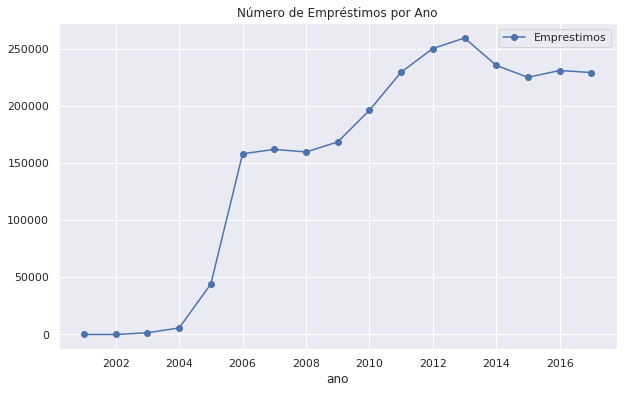

In [15]:
# Plot de linha do andamento dos emprestimos nos anos
emprestimos_ano.plot(kind='line', title="Número de Empréstimos por Ano", legend=True, figsize=(10,6), style=["o-"])
plt.show()

O começo lento se dá pois os livros e os dados dos emprestimos estava começando a serem cadastrados.
O grande crescimento entre 2004 e 2006 ocorreu provavelmente pelo melhor controle sobre o cadastro dos emprestimos no sistema onde os dados foram coletados.

In [16]:
# Preparando os dados dos exemplares emprestados
codigos_livros_emprestados = emprestimos_all.codigo_barras.value_counts()
codigos_livros_emprestados = pd.DataFrame(codigos_livros_emprestados)
codigos_livros_emprestados = codigos_livros_emprestados.reset_index()
codigos_livros_emprestados.columns = ["codigo_barras", "count"]

In [17]:
# Simplificando os dados do acervo, selecionando algumas colunas
bib_ex = exemplares[["registro_sistema", "codigo_barras"]]
# Selecionando algumas colunas interessantes sobre os livros no acervo
acervo_basic = exemplares_acervo[["registro_sistema", "titulo", "sub_titulo"]]
# Selecionando algumas colunas do dataset de emprestimos
emprestimos_simples = emprestimos_all[['codigo_barras', 'data_emprestimo','data_devolucao', 'nome_usuario']]

In [18]:
# Realizando o merge com o acervo
emprestimos_reg_sistema = pd.merge(emprestimos_simples, bib_ex, on="codigo_barras")

In [19]:
# Organizando por usuario e pelo registro no sistema
emprestimos_reg_sistema_sorted = emprestimos_reg_sistema.sort_values(["nome_usuario", "registro_sistema"])

In [20]:
# Convertendo o tempo de emprestimo com base nas datas cadastradas
emprestimos_reg_sistema_sorted["tempo_com_livro"] = (pd.to_datetime(emprestimos_reg_sistema_sorted["data_devolucao"]) - pd.to_datetime(emprestimos_reg_sistema_sorted["data_emprestimo"]))

In [21]:
# Calculando o tempo em dias da duração do emprestimo
emprestimos_reg_sistema_sorted["dias_com_livro"] = emprestimos_reg_sistema_sorted["tempo_com_livro"].dt.days

In [22]:
# Eliminando possiveis erros dos dados
emprestimos_reg_sistema_sorted = emprestimos_reg_sistema_sorted[emprestimos_reg_sistema_sorted["dias_com_livro"] > 0]

In [23]:
# Selecionando o intervalo de dias a ser plotado no grafico
to_plot = emprestimos_reg_sistema_sorted[["codigo_barras", "dias_com_livro"]]
to_plot = to_plot[(to_plot.dias_com_livro <= 60) & (to_plot.dias_com_livro > 0)]

In [24]:
# Renomenado as colunas para o gráfico
to_plot.columns = ["Código de Barras", "Dias com o Livro"]

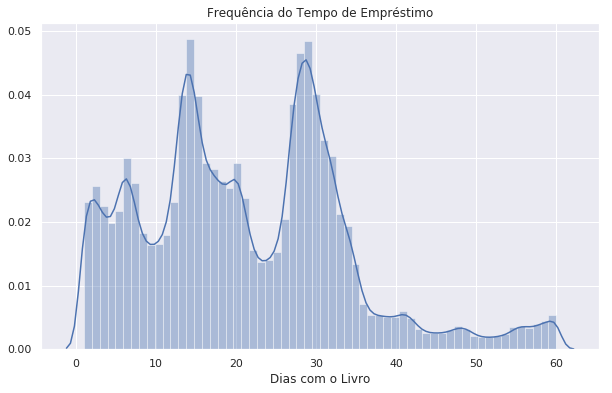

In [35]:
# Plotando o gráfico da Frequência dos Tempos dos Empréstimos
fig, ax = plt.subplots(figsize=(10, 6))
g = sns.distplot(to_plot["Dias com o Livro"], bins=60, ax=ax)
g.set_title("Frequência do Tempo de Empréstimo")
plt.show()

Podemos perceber que os picos dos tempos de emprestimos ocorrem no fim dos prazos de entrega, seja o normal ou após renovação. 15 dias e 30 dias respectivamente

In [26]:
# Agrupando os dados dos emprestimos com base no registro do sistema e somando o tempo em dias do emprestimo.
livros_mais_dias = emprestimos_reg_sistema_sorted.groupby("registro_sistema")["dias_com_livro"].sum()

In [27]:
# Organizando melhor os dados obtidos pelo agrupamento anterior 
livros_mais_dias = pd.DataFrame(livros_mais_dias.sort_values(ascending=False))
livros_mais_dias = livros_mais_dias.reset_index()

In [28]:
# Realizando o merge dos livros e seus tempos de emprestimos com seus dados no acervo
livros_interessantes_dias = pd.merge(livros_mais_dias, acervo_basic, on="registro_sistema")
livros_interessantes_dias = livros_interessantes_dias[livros_interessantes_dias.dias_com_livro > 0]

In [29]:
# Selecionando as colunas que irão para o plot
livros_interessantes_dias_plot = livros_interessantes_dias[["titulo", "dias_com_livro"]]
livros_interessantes_dias_plot = livros_interessantes_dias_plot.drop_duplicates("titulo")
# Renomeando as colunas para o plot
livros_interessantes_dias_plot.columns = ["Titulo", "Dias com o Livro"]
livros_interessantes_dias_plot["Anos Emprestado"] = livros_interessantes_dias_plot["Dias com o Livro"]/365

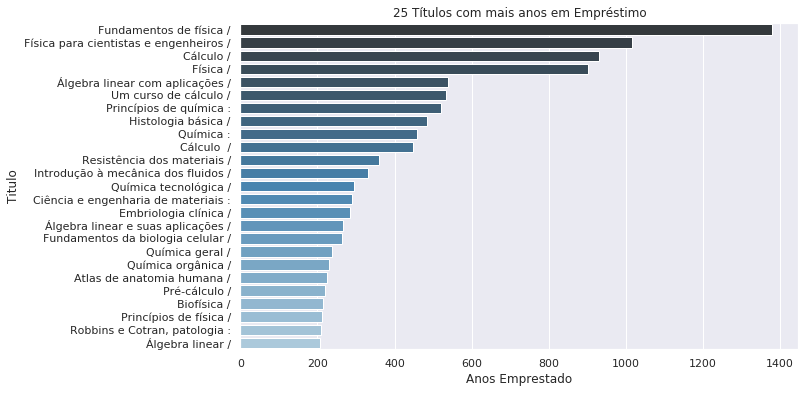

In [30]:
# Preparando a figura e plotando o gráfico
fig, ax = plt.subplots(figsize=(10, 6))
g = sns.barplot(ax=ax, data=livros_interessantes_dias_plot.head(25), x="Anos Emprestado", y='Titulo', palette="Blues_d")
g.set_title("25 Títulos com mais anos em Empréstimo")
plt.show()

In [31]:
# Contando o numero de emprestimos por livro com base no registro no sistema
numero_emprestimos_por_livro = emprestimos_reg_sistema_sorted.registro_sistema.value_counts()
numero_emprestimos_por_livro = pd.DataFrame(numero_emprestimos_por_livro)
numero_emprestimos_por_livro = numero_emprestimos_por_livro.reset_index()
numero_emprestimos_por_livro.columns = ["registro_sistema","Emprestimos"]

In [32]:
# Realizando o merge do numero de emprestimos dos livros e seus dados no acervo
livros_interessantes_numero = pd.merge(numero_emprestimos_por_livro, acervo_basic, on="registro_sistema")

In [33]:
# Selecionando as colunas que irão para o plot
livros_interessantes_numero_plot = livros_interessantes_numero[["titulo", "Emprestimos"]]
livros_interessantes_numero_plot = livros_interessantes_numero_plot.drop_duplicates("titulo")
# Renomeando as colunas para o plot
livros_interessantes_numero_plot.columns = ["Titulo", "Empréstimos"]

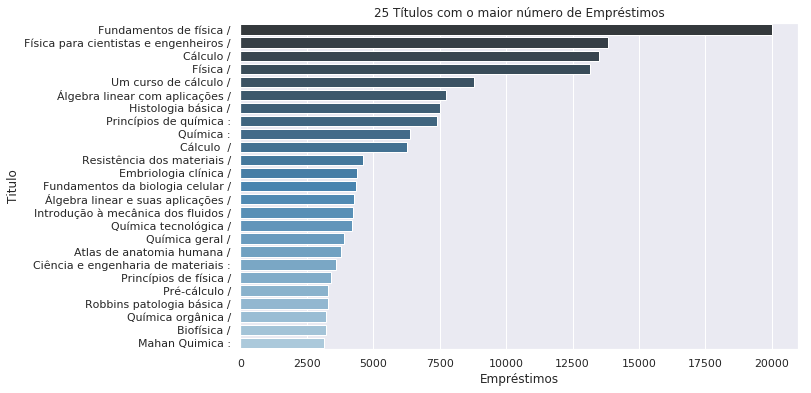

In [34]:
# Preparando a figura e plotando o gráfico
fig, ax = plt.subplots(figsize=(10, 6))
g = sns.barplot(ax=ax,data=livros_interessantes_numero_plot.head(25), x="Empréstimos", y="Titulo", palette="Blues_d", orient="h")
g.set_title("25 Títulos com o maior número de Empréstimos")
plt.show()